The Kontinental Hockey League (KHL) (Russian: Континентальная хоккейная лига (КХЛ), Kontinental'naya hokkeynaya liga) is an international professional ice hockey league founded in 2008. It comprises 24 member clubs based in Belarus, China, Finland, Latvia, Kazakhstan and Russia, and it is planned to expand to more countries. It is widely considered to be the premier professional ice hockey league in Europe and Asia, and second in the world behind the National Hockey League. KHL has the third highest average attendance in Europe with 6,121 spectators per game in the regular season, and the highest total attendance in Europe with 5.32 million spectators in the regular season.

In [5]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Information from site: https://allhockey.ru/stat/

Add column 'position':
- 'F' - forward
- 'D' - defenceman

In [14]:
res0 = requests.get('https://allhockey.ru/stat/players?page=search&lid=1&sid=7&ttid=3&tpid=2&tmid=0&sort=1-u&numpage=1')
soup0 = BeautifulSoup(res0.content, 'html.parser')

max_step_f = int(soup0.find_all('a', 'step')[-1].text)

res0 = requests.get('https://allhockey.ru/stat/players?page=search&lid=1&sid=7&ttid=3&tpid=3&tmid=0&sort=1-u&numpage=1')
soup0 = BeautifulSoup(res0.content, 'html.parser')

max_step_d = int(soup0.find_all('a', 'step')[-1].text)

df_f = pd.DataFrame()

def get_players(pos, max_step):
    position = {'F': '2', 'D': '3'}
    df = pd.DataFrame()
    for step in range(1, max_step + 1):
        link = 'https://allhockey.ru/stat/players?page=search&lid=1&sid=7&ttid=3&tpid={0}&tmid=0&sort=1-u&numpage={1}'.\
                      format(position[pos] ,step)
        res = requests.get(link)
        
        soup = BeautifulSoup(res.content, 'html.parser')
        k = []
        for i in soup.find_all('table')[1].find_all('tr')[1:]:
            l = []
            for j in i.find_all('td'):
                l.append(j.text)
            k.append(l)

        df = pd.concat([df, pd.DataFrame(k)], ignore_index = True)

    df.columns = ["player", "team", "games", "goals", "assists", "points", 
                    "pl_min", "shoots", "per_shoots", "penalty_time", "avr_time_on_ice"]
    df['position'] = pos
    return(df)


df = pd.concat([get_players('F', max_step_f), get_players('D',max_step_d)], ignore_index = True)

int_columns = ['games', 'goals', 'assists', 'points', 'pl_min', 'shoots', 'penalty_time']
df[int_columns] = df[int_columns].apply(lambda x: x.astype('int16'))
df['per_shoots'] = df['per_shoots'].astype('float32')

    


In [15]:
df_ = df.sort_values(['team','player'])
df_.head(5)

,player,team,games,goals,assists,points,pl_min,shoots,per_shoots,penalty_time,avr_time_on_ice,position
25,Бек Тэйлор,АВГ,56,19,17,36,8,145,13.1,28,18:36,F
546,Березин Максим,АВГ,30,2,2,4,9,31,6.5,2,10:31,D
556,Бондарев Алексей,АВГ,26,0,4,4,7,10,0.0,4,08:04,D
64,Верстиг Крис,АВГ,11,3,2,5,-1,34,8.8,0,16:32,F
81,Галимов Ансель,АВГ,45,5,6,11,5,52,9.6,23,09:36,F


Columns:
- player - player name
- team - team name
    

##### Top 10 teams with most points and goals per player (forwards)

In [16]:
df_[df_['position'] == 'F'].groupby('team').\
    agg({'points': 'median', 'goals': 'median'}).sort_values(['points', 'goals'], ascending=False).head(10)

,points,goals
team,,
ТОР,18.0,6.0
ЙОК,16.0,6.5
ММГ,15.0,7.0
ЦСК,14.0,7.0
БАР,13.5,6.5
СКА,11.5,5.0
АКБ,11.0,7.0
АДМ,11.0,5.5
СИБ,11.0,5.5


##### Add columns (params per player for one game):
- 'penalty_time_pp'- penalty
- Goals 
- 


In [ ]:
df_['penalty_time_pp'] = df_['penalty_time'] / df_['games']
df_['goals_pp'] = df_['goals'] / df_['games']
df_['points_pp'] = df_['points'] / df_['games']
df_

### Time on ice
avr_time_on_ice - mm:ss.
Let's transform it to seconds only

In [29]:
def time_to_seconds(t):
    l = t.split(':')
    return(int(l[0]) * 60 + int(l[1]))

df_['avr_time_on_ice_sec'] = df_['avr_time_on_ice'].apply(lambda x: time_to_seconds(x))

,player,team,games,goals,assists,points,pl_min,shoots,per_shoots,penalty_time,avr_time_on_ice,position,penalty_time_pp,goals_pp,points_pp,avr_time_on_ice_sec
25,Бек Тэйлор,АВГ,56,19,17,36,8,145,13.1,28,18:36,F,0.500000,0.339286,0.642857,1116
546,Березин Максим,АВГ,30,2,2,4,9,31,6.5,2,10:31,D,0.066667,0.066667,0.133333,631
556,Бондарев Алексей,АВГ,26,0,4,4,7,10,0.0,4,08:04,D,0.153846,0.000000,0.153846,484
64,Верстиг Крис,АВГ,11,3,2,5,-1,34,8.8,0,16:32,F,0.000000,0.272727,0.454545,992
81,Галимов Ансель,АВГ,45,5,6,11,5,52,9.6,23,09:36,F,0.511111,0.111111,0.244444,576


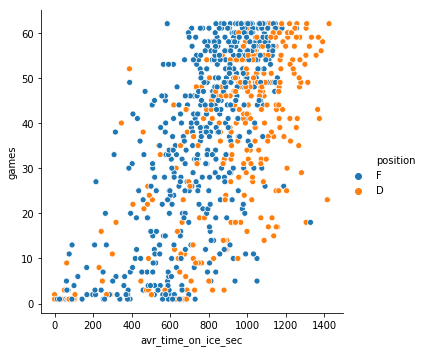

In [40]:
sns.relplot(x = 'avr_time_on_ice_sec', y = 'games', hue = 'position', data = df_);

The longer the player’s average time on ice, the more games he played in a season. Visually there is a linear relationship.

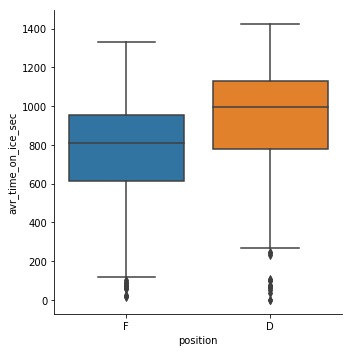

In [44]:
sns.catplot(x = 'position', y = 'avr_time_on_ice_sec', kind = 'box', data = df_);

The average time on the ice of the defencemen is longer than that of the forwards.

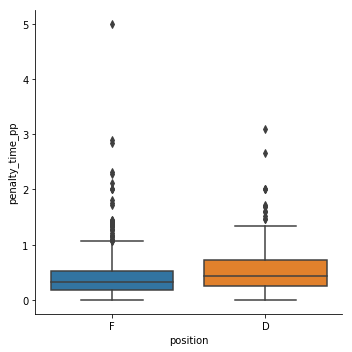

In [45]:
sns.catplot(x = 'position', y = 'penalty_time_pp', kind = 'box', data = df_);

Defendcemen, on average, more often serve a penalty time than forwards.

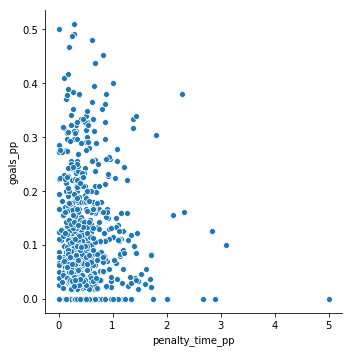

In [39]:
sns.relplot(x = 'penalty_time_pp', y = 'goals_pp', data = df_);

In [ ]:
##### Distribution Average time on ice

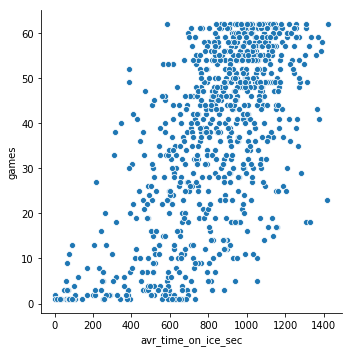

In [35]:
sns.relplot(x = 'avr_time_on_ice_sec', y = 'games', data = df_);

##### Distribution Average time on ice

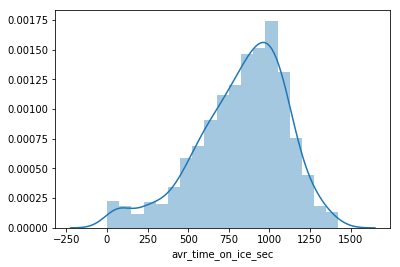

In [34]:
sns.distplot(df_.avr_time_on_ice_sec);